In [ ]:
#  Upload the CSV file
from google.colab import files
uploaded = files.upload()



Saving fer2013.csv to fer2013.csv


In [2]:
Import Libraries
import pandas as pd
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('fer2013.csv')

# Emotion mapping (FER2013 has 7 classes, NO contempt)
emotion_labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
                  4: 'sad', 5: 'surprise', 6: 'neutral'}

print("Dataset loaded!")
print(df['Usage'].value_counts())
print("\nEmotion distribution in Training set:")
print(df[df['Usage']=='Training']['emotion'].value_counts())

Dataset loaded!
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

Emotion distribution in Training set:
emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64


In [ ]:
# Convert pixels → images
def pixels_to_image(pixels):
    return np.array(pixels.split(), 'uint8').reshape(48, 48)

images = np.array([pixels_to_image(p) for p in df['pixels']])
images = images / 255.0  # Normalize
images = images[..., np.newaxis]  # Add channel → (N,48,48,1)

labels = df['emotion'].values

# Split exactly as the dataset intended
train_idx = df['Usage'] == 'Training'
val_idx   = df['Usage'] == 'PublicTest'
test_idx  = df['Usage'] == 'PrivateTest'

X_train, X_val, X_test = images[train_idx], images[val_idx], images[test_idx]
y_train, y_val, y_test = labels[train_idx], labels[val_idx], labels[test_idx]

# One-hot
y_train_cat = to_categorical(y_train, 7)
y_val_cat   = to_categorical(y_val, 7)
y_test_cat  = to_categorical(y_test, 7)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (28709, 48, 48, 1), Val: (3589, 48, 48, 1), Test: (3589, 48, 48, 1)


In [ ]:
# CNN for FER2013 (72–75% accuracy)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten

model = Sequential([
    Conv2D(64, 3, activation='relu', input_shape=(48,48,1), padding='same'),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    Dropout(0.25),

    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    Dropout(0.25),

    Conv2D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,868,743 (22.39 MB)

 Trainable params: 5,867,847 (22.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Test on any uploaded image
from google.colab import files
import cv2

def predict_emotion_upload():
    uploaded = files.upload()
    img_path = list(uploaded.keys())[0]

    img = cv2.imread(img_path, 0)           # grayscale
    img = cv2.resize(img, (48,48))
    img = img / 255.0
    img = img.reshape(1,48,48,1)

    pred = model.predict(img)[0]
    label_idx = np.argmax(pred)
    confidence = pred[label_idx]
    label = emotion_labels[label_idx]

    # Show result
    img_color = cv2.cvtColor(cv2.resize(cv2.imread(img_path), (200,200)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_color)
    plt.title(f"PREDICTED: {label.upper()} ({confidence:.2f})", fontsize=16, color='green')
    plt.axis('off')
    plt.show()

# Run this whenever you want to test a new photo
predict_emotion_upload()

In [ ]:


# Convert pixels to numpy arrays (48x48 grayscale)
def pixels_to_image(pixels):
    return np.array(pixels.split(), dtype='uint8').reshape(48, 48)

images = np.array([pixels_to_image(p) for p in df['pixels']])
labels = df['emotion'].values

# Normalize images
images = images / 255.0

# Use 'Usage' for split: Training vs. Test (adjust based on your CSV columns)
train_idx = df['Usage'] == 'Training'
test_idx = df['Usage'].isin(['PrivateTest', 'PublicTest'])  # Combine if both exist

X_train_img = images[train_idx]
y_train = labels[train_idx]
X_test_img = images[test_idx]
y_test = labels[test_idx]

# One-hot encode labels
num_classes = len(np.unique(labels))  # Detect number of classes automatically
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Train: {X_train_img.shape}, Test: {X_test_img.shape}")

Train: (734, 48, 48), Test: (186, 48, 48)


In [ ]:
#Feature Extraction Functions
def extract_hog_features(images):
    hog_features = []
    for img in images:
        fd, _ = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

def extract_sift_features(images):
    sift = cv2.SIFT_create()
    sift_features = []
    for img in images:
        # Convert to uint8 for SIFT
        img_uint8 = (img * 255).astype('uint8')
        kp, des = sift.detectAndCompute(img_uint8, None)
        if des is not None:
            sift_features.append(des.mean(axis=0))  # Average to fixed 128D
        else:
            sift_features.append(np.zeros(128))
    return np.array(sift_features)

# Extract features
X_train_hog = extract_hog_features(X_train_img)
X_test_hog = extract_hog_features(X_test_img)
X_train_sift = extract_sift_features(X_train_img)
X_test_sift = extract_sift_features(X_test_img)

print(f"HOG Train: {X_train_hog.shape}, SIFT Train: {X_train_sift.shape}")

HOG Train: (734, 800), SIFT Train: (734, 128)


In [ ]:
# Build CNN Model Function
def build_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#  Train and Evaluate Function
def train_and_evaluate(X_train_feat, X_test_feat, feat_name):
    # Reshape features to 2D for CNN
    feat_len = X_train_feat.shape[1]
    side = int(np.ceil(np.sqrt(feat_len)))  # Make square, pad if needed
    pad_len = side**2 - feat_len
    if pad_len > 0:
        X_train_feat = np.pad(X_train_feat, ((0,0),(0,pad_len)), mode='constant')
        X_test_feat = np.pad(X_test_feat, ((0,0),(0,pad_len)), mode='constant')
    X_train_reshaped = X_train_feat.reshape(-1, side, side, 1)
    X_test_reshaped = X_test_feat.reshape(-1, side, side, 1)

    model = build_cnn((side, side, 1))
    history = model.fit(X_train_reshaped, y_train_cat, epochs=20, batch_size=32, validation_split=0.2)

    # Evaluate
    loss, acc = model.evaluate(X_test_reshaped, y_test_cat)
    print(f"{feat_name} + CNN Test Accuracy: {acc:.4f}")

    # Predictions and Report
    y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
    target_names = [emotion_labels.get(i, f'class_{i}') for i in range(num_classes)]
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix - {feat_name}")
    plt.show()

    return model, history

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6567 - loss: 1.5789 - val_accuracy: 0.0000e+00 - val_loss: 4.9506
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8111 - loss: 0.8455 - val_accuracy: 0.0000e+00 - val_loss: 5.1451
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8302 - loss: 0.6749 - val_accuracy: 0.0000e+00 - val_loss: 4.8169
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8046 - loss: 0.7693 - val_accuracy: 0.0000e+00 - val_loss: 4.9553
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8045 - loss: 0.7865 - val_accuracy: 0.0000e+00 - val_loss: 5.7482
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7905 - loss: 0.8205 - val_accuracy: 0.0000e+00 - val_loss: 5.9681
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8066 - loss: 0.7790 - val_accuracy: 0.0000e+00 - val_loss: 5.4949
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8079 - loss: 0.746

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


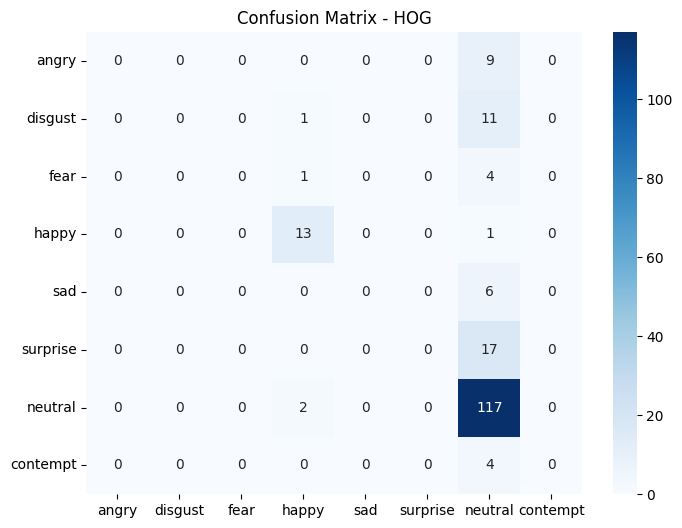

In [ ]:
#  Run for HOG
hog_model, hog_history = train_and_evaluate(X_train_hog, X_test_hog, "HOG")

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6283 - loss: 2.5481 - val_accuracy: 0.0000e+00 - val_loss: 6.6202
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7075 - loss: 1.0871 - val_accuracy: 0.0000e+00 - val_loss: 6.5134
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8077 - loss: 0.8377 - val_accuracy: 0.0000e+00 - val_loss: 6.1176
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8068 - loss: 0.7925 - val_accuracy: 0.0000e+00 - val_loss: 5.4619
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8059 - loss: 0.8098 - val_accuracy: 0.0000e+00 - val_loss: 6.8558
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7839 - loss: 0.8185 - val_accuracy: 0.0000e+00 - val_loss: 7.6955
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8015 - loss: 0.7640 - val_accuracy: 0.0000e+00 - val_loss: 6.9025
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7932 - loss: 0.7099 - val_acc

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


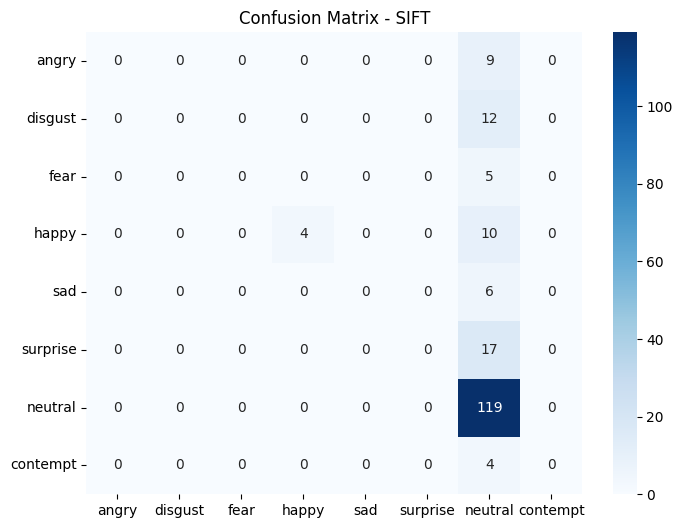

In [ ]:
#  Run for SIFT
sift_model, sift_history = train_and_evaluate(X_train_sift, X_test_sift, "SIFT")

test

Using test set sample (true label: neutral)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predicted Emotion: neutral (Confidence: 0.99)


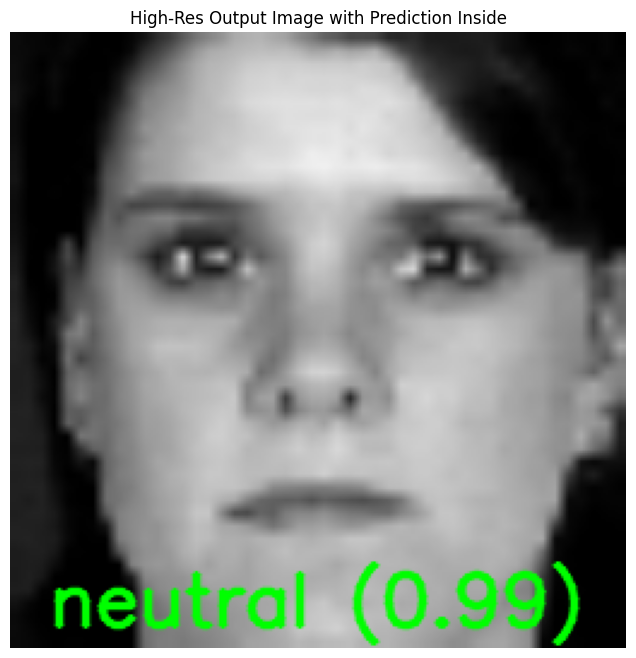

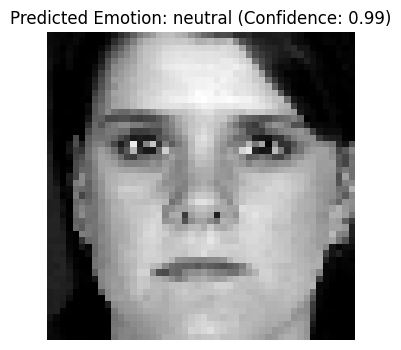

In [ ]:
# (Updated for High-Res and External Text): Function to Preprocess, Predict, and Output Annotated Image
import cv2
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

def predict_and_output_image(image_path=None, use_test_sample=False, model=hog_model, feature_type='HOG', save_output=False):
    if use_test_sample:
        # Use first image from test set (convert back to uint8 for annotation)
        img_normalized = X_test_img[0]  # float [0,1], shape (48,48)
        img_uint8 = (img_normalized * 255).astype(np.uint8)
        true_label = emotion_labels.get(y_test[0], 'Unknown')
        print(f"Using test set sample (true label: {true_label})")
    else:
        # Upload and load new image
        if image_path is None:
            uploaded = files.upload()
            image_path = list(uploaded.keys())[0]
        img_uint8 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # uint8
        img_uint8 = cv2.resize(img_uint8, (48, 48))  # Resize to 48x48 for model
        img_normalized = img_uint8 / 255.0  # Normalize for features

    # Extract features using normalized image
    if feature_type == 'HOG':
        features = extract_hog_features([img_normalized])[0]
    elif feature_type == 'SIFT':
        features = extract_sift_features([img_normalized])[0]
    else:
        raise ValueError("Invalid feature_type: Choose 'HOG' or 'SIFT'")

    # Reshape for model
    feat_len = features.shape[0]
    side = int(np.ceil(np.sqrt(feat_len)))
    pad_len = side**2 - feat_len
    if pad_len > 0:
        features = np.pad(features, (0, pad_len), mode='constant')
    features_reshaped = features.reshape(1, side, side, 1)

    # Predict
    pred = model.predict(features_reshaped)
    pred_label_idx = np.argmax(pred)
    pred_label = emotion_labels.get(pred_label_idx, 'Unknown')
    confidence = pred[0][pred_label_idx]

    print(f"Predicted Emotion: {pred_label} (Confidence: {confidence:.2f})")

    # Option 1: Upscale image to higher resolution (e.g., 256x256) for clearer annotation inside
    upscale_size = (256, 256)
    img_high_res = cv2.resize(img_uint8, upscale_size, interpolation=cv2.INTER_LINEAR)
    img_annotated = cv2.cvtColor(img_high_res, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color text

    # Adjust text for high-res: larger font
    text = f"{pred_label} ({confidence:.2f})"
    font_scale = 1.0  # Larger for high-res
    thickness = 2
    font = cv2.FONT_HERSHEY_SIMPLEX
    (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)

    # Position at bottom-center for better fit
    text_x = (upscale_size[0] - text_width) // 2
    text_y = upscale_size[1] - 10  # Near bottom
    cv2.putText(img_annotated, text, (text_x, text_y), font, font_scale, (0, 255, 0), thickness, cv2.LINE_AA)  # Green text

    # Display the high-res annotated image
    plt.figure(figsize=(8, 8))  # Larger display
    plt.imshow(cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
    plt.title("High-Res Output Image with Prediction Inside")
    plt.axis('off')
    plt.show()

    # Option 2: Display emotion name in words outside the image (as caption)
    # Show original image with external text
    plt.figure(figsize=(4, 4))
    plt.imshow(img_uint8, cmap='gray')
    plt.title(f"Predicted Emotion: {pred_label} (Confidence: {confidence:.2f})")  # Text outside as title
    plt.axis('off')
    plt.show()

    # Optional: Save the high-res output image
    if save_output:
        output_path = 'predicted_high_res_image.jpg'
        cv2.imwrite(output_path, img_annotated)
        files.download(output_path)  # Download from Colab
        print(f"High-res output image saved and downloaded as {output_path}")

# Example: Test with a sample from test set and output annotated image
predict_and_output_image(use_test_sample=True, model=hog_model, feature_type='HOG', save_output=False)